In [26]:
import seaborn as sns
# set font-scale
sns.set(style="whitegrid", context="notebook",font_scale=1.2)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [27]:
def load_csvs_into_df(dir):
    dirs = [os.path.join(dir,d) for d in os.listdir(dir) if os.path.isdir(os.path.join(dir,d))]
    dfs = []
    for d in dirs:
        seeds = [f for f in os.listdir(os.path.join('./',d)) if f.startswith('seed')]
        for seed in seeds:
            results = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('test_results')][0]
            results_df = pd.read_csv(os.path.join(d, seed, results))
            dfs.append(results_df)
    df = pd.concat(dfs)
    return df

In [28]:
df = load_csvs_into_df('./')

In [29]:
# only keep relevant columns
df = df[['seed','effective_dataset_size','test/lungOpacity_young_subgroupAUROC','test/lungOpacity_old_subgroupAUROC','protected_attr_percent']]

In [30]:
df = pd.melt(df, id_vars=['seed','protected_attr_percent','effective_dataset_size'], value_vars=['test/lungOpacity_young_subgroupAUROC','test/lungOpacity_old_subgroupAUROC'])

In [31]:
# replace variable names
print(df.variable.unique())
df.variable = df.variable.str.replace('test/lungOpacity_young_subgroupAUROC','young')
df.variable = df.variable.str.replace('test/lungOpacity_old_subgroupAUROC','old')
df.head()

['test/lungOpacity_young_subgroupAUROC'
 'test/lungOpacity_old_subgroupAUROC']


,seed,protected_attr_percent,effective_dataset_size,variable,value
0,2,0.5,0.008,young,0.5908
1,1,0.5,0.008,young,0.6512
2,5,0.5,0.008,young,0.6236
3,3,0.5,0.008,young,0.6540
4,4,0.5,0.008,young,0.6530


In [32]:
# load effective_dataset_size 1 
df_1 = load_csvs_into_df('../2023-09-02 22:38:35-FAE-rsna-age-bs32-noDP')
df_1 = df_1[['seed','test/lungOpacity_young_subgroupAUROC','test/lungOpacity_old_subgroupAUROC','protected_attr_percent']]
df_1['effective_dataset_size'] = 1
df_1 = pd.melt(df_1, id_vars=['seed','protected_attr_percent','effective_dataset_size'], value_vars=['test/lungOpacity_young_subgroupAUROC','test/lungOpacity_old_subgroupAUROC'])
df_1 = df_1[df_1.protected_attr_percent.isin([0.5])]
print(df.variable.unique())
df_1.variable = df_1.variable.str.replace('test/lungOpacity_young_subgroupAUROC','young')
df_1.variable = df_1.variable.str.replace('test/lungOpacity_old_subgroupAUROC','old')
df_1.head()

['young' 'old']


,seed,protected_attr_percent,effective_dataset_size,variable,value
20,2,0.5,1,young,0.7648
21,1,0.5,1,young,0.7440
22,5,0.5,1,young,0.7366
23,3,0.5,1,young,0.7466
24,4,0.5,1,young,0.7380


In [33]:
# concat df and df_1
df = pd.concat([df,df_1])

In [34]:
# sort df by effective_dataset_size
df = df.sort_values(by=['effective_dataset_size',"variable"], ascending=False)

In [35]:
sizes = df.effective_dataset_size.unique()

best_dss 4 0.001


/home/getznerj/miniconda3/envs/thesis_opacus/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/getznerj/miniconda3/envs/thesis_opacus/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/getznerj/miniconda3/envs/thesis_opacus/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/getznerj/miniconda3/envs/thesis_opacus/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

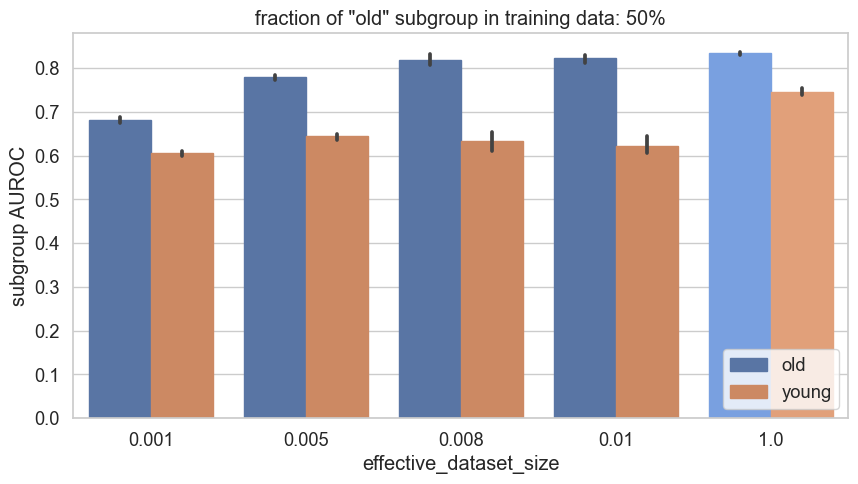

In [36]:
plt.figure(figsize=(10,5))
# over all weights get weight with minimum dist between young and old subgroup AUROC
min_dist = np.inf
best_dss = None
best_dss_max = None
best_dss_min = None
for idx, w in enumerate(sizes):
    sub_w = df[df.effective_dataset_size==w]
    # compute dist between max and min of value column
    dist = sub_w.value.max() - sub_w.value.min()
    if dist < min_dist:
        min_dist = dist
        best_dss = idx
        best_dss_max = sub_w.value.max()
        best_dss_min = sub_w.value.min()
print("best_dss", best_dss, sizes[best_dss])
# sort sub by variable
df = df.sort_values(by=['variable'], ascending=True)
g = sns.barplot(data=df, x="effective_dataset_size", y="value", hue="variable")
custom_colors = ["#5975A4"]*4 + ["#79a0e0"] + ["#CC8963"]*4 + ["#e1a07a"]
for i, bar in enumerate(g.patches):
    bar.set_color(custom_colors[i])
plt.title(f'fraction of "old" subgroup in training data: {0.5*100:.0f}%')
# set axis labels
plt.xlabel('effective_dataset_size')
plt.ylabel('subgroup AUROC')
plt.legend(loc="lower right")
plt.show()